In [ ]:
!pip install xgboost scikit-learn

import os
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = "/content/drive/MyDrive/CSI"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def process_csv(filepath):
    df = pd.read_csv(filepath)
    amp = extract_amplitude_features(df)
    if amp.size == 0:
        raise ValueError("Amplitude array is empty")
    feature_vector = np.concatenate([
        amp.mean(axis=0),
        amp.std(axis=0),
        np.max(amp, axis=0),
        np.min(amp, axis=0)
    ])
    return feature_vector


In [ ]:
# 복소수 CSI → 진폭 변환 함수
def extract_amplitude_features(df):
    amplitude_matrix = []
    for col in df.columns:
        if re.match(r'^_\d+$', col):  # _0 ~ _63
            cleaned = []
            for val in df[col].dropna():
                try:
                    c = complex(str(val).replace("(", "").replace(")", "").replace(" ", "").replace("nan", "0"))
                    cleaned.append(abs(c))
                except Exception:
                    cleaned.append(np.nan)
            amplitude_matrix.append(np.array(cleaned))
    result = np.array(amplitude_matrix).T if amplitude_matrix else np.array([])
    return result

In [ ]:
# 단일 CSV → 통계 기반 벡터
def load_flat_dataset(folder_path):
    X, y = [], []
    label_map = {}
    files = sorted([f for f in os.listdir(folder_path) if f.lower().endswith('.csv')])
    print(f"CSV 파일 수: {len(files)}")

    for file in files:
        class_name = "_".join(file.split("_")[:3])  # 예: hands_up_bath
        if class_name not in label_map:
            label_map[class_name] = len(label_map)
        label = label_map[class_name]

        file_path = os.path.join(folder_path, file)
        try:
            features = process_csv(file_path)
            X.append(features)
            y.append(label)
            print(f"{file} → 라벨 {label}")
        except Exception as e:
            print(f"❌ 처리 실패: {file} | 에러: {e}")

    return np.array(X), np.array(y), label_map


In [ ]:
X, y, label_map = load_flat_dataset(data_dir)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("클래스 라벨 매핑:", label_map)

CSV 파일 수: 80
hands_up_bath_1.csv → 라벨 0
hands_up_bath_10.csv → 라벨 0
hands_up_bath_11.csv → 라벨 0
hands_up_bath_12.csv → 라벨 0
hands_up_bath_13.csv → 라벨 0
hands_up_bath_14.csv → 라벨 0
hands_up_bath_15.csv → 라벨 0
hands_up_bath_16.csv → 라벨 0
hands_up_bath_17.csv → 라벨 0
hands_up_bath_18.csv → 라벨 0
hands_up_bath_19.csv → 라벨 0
hands_up_bath_2.csv → 라벨 0
hands_up_bath_20.csv → 라벨 0
hands_up_bath_3.csv → 라벨 0
hands_up_bath_4.csv → 라벨 0
hands_up_bath_5.csv → 라벨 0
hands_up_bath_6.csv → 라벨 0
hands_up_bath_7.csv → 라벨 0
hands_up_bath_8.csv → 라벨 0
hands_up_bath_9.csv → 라벨 0
hands_up_bed_1.csv → 라벨 1
hands_up_bed_10.csv → 라벨 1
hands_up_bed_11.csv → 라벨 1
hands_up_bed_12.csv → 라벨 1
hands_up_bed_13.csv → 라벨 1
hands_up_bed_14.csv → 라벨 1
hands_up_bed_15.csv → 라벨 1
hands_up_bed_16.csv → 라벨 1
hands_up_bed_17.csv → 라벨 1
hands_up_bed_18.csv → 라벨 1
hands_up_bed_19.csv → 라벨 1
hands_up_bed_2.csv → 라벨 1
hands_up_bed_20.csv → 라벨 1
hands_up_bed_3.csv → 라벨 1
hands_up_bed_4.csv → 라벨 1
hands_up_bed_5.csv → 라벨 1
hands_up_

In [ ]:
# XGBoost
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 파이프라인 구성 및 모델 학습
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    ))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:01:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 600x600 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128216 (\N{BLUE BOOK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54844 (\N{HANGUL SYLLABLE HON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54665 (\N{HANGUL SYLLABLE HAENG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47148 (\N{HANGUL SYLLABLE RYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


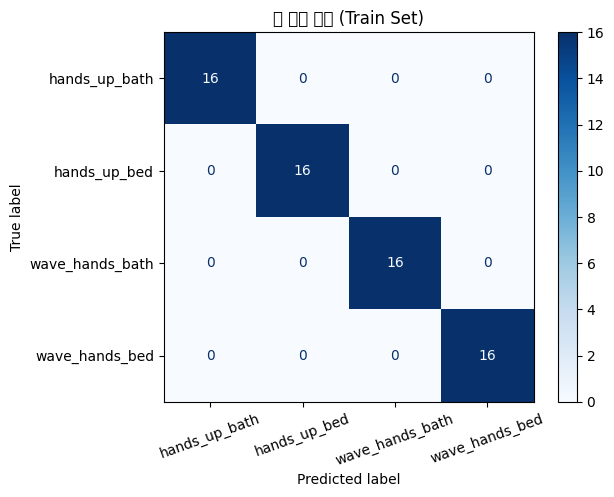

<Figure size 600x600 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128217 (\N{ORANGE BOOK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54844 (\N{HANGUL SYLLABLE HON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54665 (\N{HANGUL SYLLABLE HAENG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47148 (\N{HANGUL SYLLABLE RYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


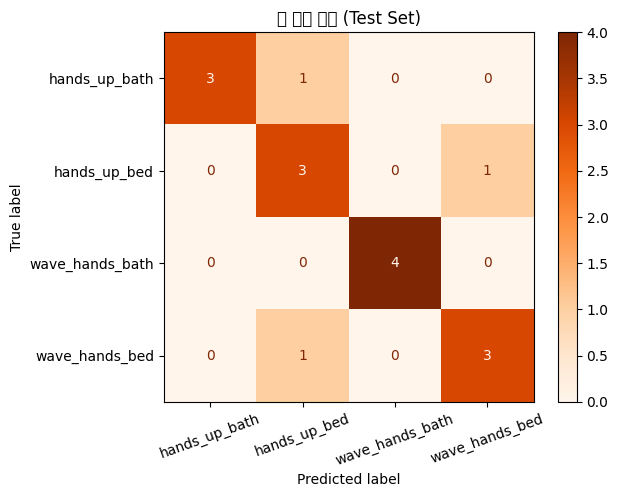

In [ ]:
# 예측 결과 생성
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# 혼동 행렬 (Train)
cm_train = confusion_matrix(y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=class_names)
plt.figure(figsize=(6, 6))
disp_train.plot(cmap='Blues', values_format='d')
plt.title("📘 혼동 행렬 (Train Set)")
plt.xticks(rotation=20)
plt.show()

# 혼동 행렬 (Test)
cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=class_names)
plt.figure(figsize=(6, 6))
disp_test.plot(cmap='Oranges', values_format='d')
plt.title("📙 혼동 행렬 (Test Set)")
plt.xticks(rotation=20)
plt.show()


<ipython-input-16-f1b81e757293>:22: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-f1b81e757293>:22: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-f1b81e757293>:22: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-f1b81e757293>:22: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-f1b81e757293>:22: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-f1b81e757293>:22: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-f1b81e757293>:22: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<i

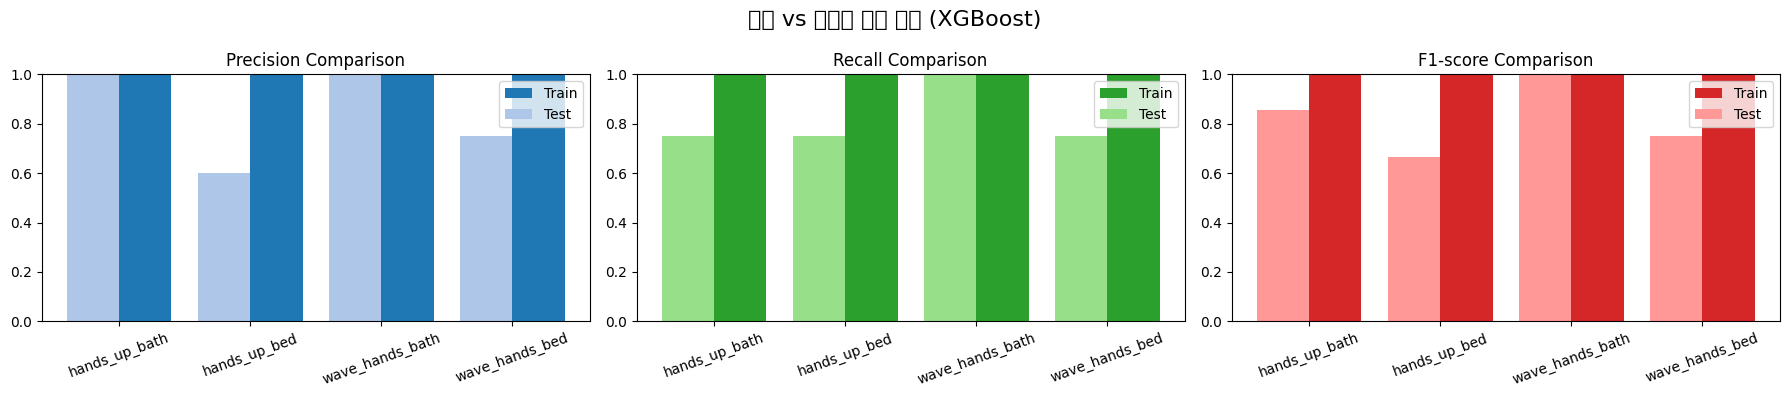

In [ ]:
metrics = ['precision', 'recall', 'f1-score']

# (Train color, Test color) per metric
color_pairs = [
    ('#1f77b4', '#aec7e8'),  # 파랑 계열
    ('#2ca02c', '#98df8a'),  # 초록 계열
    ('#d62728', '#ff9896')   # 빨강 계열
]

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

for i, metric in enumerate(metrics):
    train_color, test_color = color_pairs[i]
    axes[i].bar(train_df.index, train_df[metric], width=0.4, label='Train', color=train_color, align='edge')
    axes[i].bar(test_df.index, test_df[metric], width=-0.4, label='Test', color=test_color, align='edge')
    axes[i].set_ylim(0, 1)
    axes[i].set_title(f"{metric.capitalize()} Comparison")
    axes[i].tick_params(axis='x', rotation=20)
    axes[i].legend()

plt.suptitle("학습 vs 테스트 성능 비교 (XGBoost)", fontsize=16)
plt.tight_layout()
plt.show()

In [18]:
# 정확도 출력
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}")

Train Accuracy: 1.0000
Test Accuracy:  0.8125
